# ABL with MMC forcing

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

from scipy.optimize import root_scalar
from functools import partial

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    return np.abs(a - a0).argmin()

# Merging profiles
def tanhblend(x, x0, w):
    return 0.5*(1+np.tanh((x-x0)/w))

def tanhblendprofiles(profa, profb, x, x0, w):
    tanha = profa*(1-tanhblend(x, x0, w))
    tanhb = profb*(tanhblend(x, x0, w))
    return tanha + tanhb

def interpprofile(newz, z, prof):
    spl = CubicSpline(z, prof)
    interpprof = spl(newz)
    return interpprof
    #return np.interp(newz, z, prof)
    
def blendprofiles(newz, zA, profA, Bconst, x0, w):
    newprofA = interpprofile(newz, zA, profA)
    newprofB = Bconst*np.ones(len(newz)) #interpprofile(newz, zB, profB)
    return tanhblendprofiles(newprofA, newprofB, newz, x0, w)

In [3]:
def rootC(z, T, c):
    T1, T2, T3 = T[0], T[1], T[2]
    z1, z2, z3 = z[0], z[1], z[2]
    
    if False: #T3 < T2:
        zexp = lambda zz, cc: zz*np.exp(cc*zz)
    else:
        zexp = lambda zz, cc: np.exp(cc*zz)
    
    z1exp = zexp(z1, c)
    z2exp = zexp(z2, c)
    z3exp = zexp(z3, c)
    
    #z1exp = z1*np.exp(c*z1)
    #z2exp = z2*np.exp(c*z2)
    #z3exp = z3*np.exp(c*z3)

    LHS = (T2-T1)*(z3exp - z2exp)
    RHS = (T3-T2)*(z2exp - z1exp)
    return LHS-RHS

def findA(z, T, c):
    T1, T2, T3 = T[0], T[1], T[2]
    z1, z2, z3 = z[0], z[1], z[2]
    
    if False: #T3 < T2:
        zexp = lambda zz, cc: zz*np.exp(cc*zz)
    else:
        zexp = lambda zz, cc: np.exp(cc*zz)
    
    z1exp = zexp(z1, c)
    z2exp = zexp(z2, c)
    
    A = (T2-T1)/(z2exp - z1exp)
    return A

def findT0(z, T, c, A):
    T1, T2, T3 = T[0], T[1], T[2]
    z1, z2, z3 = z[0], z[1], z[2]
    
    if False: #T3 < T2:
        zexp = lambda zz, cc: zz*np.exp(cc*zz)
    else:
        zexp = lambda zz, cc: np.exp(cc*zz)
    
    z1exp = zexp(z1, c)
    
    T0 = T1 - A*z1exp
    return T0

def fitTemp(zdat, Tdat):
    findC = partial(rootC, zdat, Tdat)
    sol = root_scalar(findC,bracket=[-1, -1E-6])
    if sol.flag=='converged':
        c  = sol.root
        A  = findA(zdat, Tdat, c)
        T0 = findT0(zdat, Tdat, c, A)
        return c, A, T0
    else:
        print(sol)
        raise ValuError('Can not fit')
    return

def Tfunc(T, c, A, T0, zvec):
    T1, T2, T3 = T[0], T[1], T[2]
    if False: #T3 < T2:
        zexp = lambda zz, cc: zz*np.exp(cc*zz)
    else:
        zexp = lambda zz, cc: np.exp(cc*zz)
    return T0 + A*zexp(zvec, c)

def Theightblend(t):
    t0 = 2.5
    tdrop = 5.0
    if t < t0:
        return 1500.0
    elif t> t0+tdrop:
        return 750.0
    else:
        return (t-t0)*(-150.0)+1500.0

In [4]:
# Set up the MMC profiles
profiledir  ='../'
ldr_heights = np.loadtxt(profiledir+'/Uheights.dat')
ldr_time    = np.loadtxt(profiledir+'/Utimes1.dat')
ldr_WS      = np.nan_to_num(np.loadtxt(profiledir+'/WSprofiles1.dat'), 0.0)
ldr_WD      = np.nan_to_num(np.loadtxt(profiledir+'/WDprofiles1.dat'), 0.0)

b_temp      = np.loadtxt(profiledir+'/surftemp1.dat')
b_tflux     = np.loadtxt(profiledir+'/Tflux1.dat')

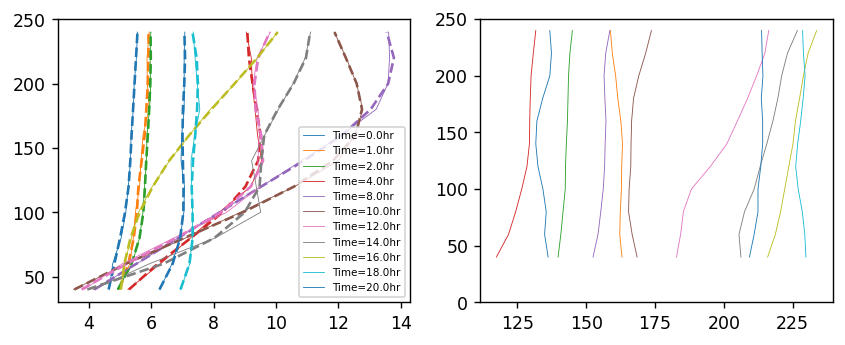

In [5]:
# Plot the original data
iplot = [0, 6, 12, 24, 48, 60, 72, 84, 96, 108, 120]
fig,ax = plt.subplots(1,2,figsize=(8,3), dpi=125)
for i in iplot:
    t = ldr_time[i]
    WSfilt = savgol_filter(ldr_WS[i,:], 7, 3)
    line,  = ax[0].plot(ldr_WS[i,:], ldr_heights, lw=0.5, label='Time=%0.1fhr'%(t/3600))
    ax[0].plot(WSfilt, ldr_heights, color=line.get_color(), linestyle='--')
    ax[1].plot(ldr_WD[i,:], ldr_heights, lw=0.5, color=line.get_color(), label='Time=%0.1fhr'%(t/3600))
plt.ylim([0, 250])
ax[0].legend(prop={'size':6})

In [6]:
extra_heights = np.arange(260, 1010, 20)
all_heights   = np.concatenate((ldr_heights, extra_heights))
all_heights0  = np.concatenate(([0], all_heights))

In [7]:
# Convert from WS to WD
all_U = []
all_V = []
extra_zeros = extra_heights*0.0

for i, t in enumerate(ldr_time):
    theta = (270.0 - ldr_WD[i,:])*np.pi/180.0
    #print(270 - ldr_WD[i,:])
    WS    = ldr_WS[i,:]
    U     = WS*np.cos(theta)
    V     = WS*np.sin(theta)
    all_U.append(U)
    all_V.append(V)
    #all_U.append(np.concatenate((U, extra_zeros)))
    #all_V.append(np.concatenate((V, extra_zeros)))
    
all_U = np.array(all_U)
all_V = np.array(all_V)

In [8]:
filterN = 11
polyN   = 3
zblend  = 240
blendw  = 25
maxzN   = 11
all_Ublend = []
all_Vblend = []
all_Tblend = []

TatBlend = 311.5

## Temperature profile
#lapserate = 8.0
#grounddT  = 2.0
#Tsurf = 278
#Tlow  = 280
#Thigh = 288
#Tprof = Tsurf + (Tlow-Tsurf)/(zblend)*all_heights

# Filter and blend to constant
for i, t in enumerate(ldr_time):
    #print(i)
    Ufilt = savgol_filter(all_U[i,:], filterN, polyN)
    Vfilt = savgol_filter(all_V[i,:], filterN, polyN)
    
    Uzblend = np.interp(zblend, ldr_heights, Ufilt)
    Vzblend = np.interp(zblend, ldr_heights, Vfilt)
    
    zblendT = 600
    expConst = 0.009
    Tground = PchipInterpolator(b_temp[:,0], b_temp[:,1],extrapolate=True)(t)
    Thigh   = TatBlend+10
    Tprof  = []
    for z in all_heights0:
        Tprof.append((Tground-TatBlend)*np.exp(-expConst*z)+TatBlend)
    
    # Merge the profiles
    blendU = blendprofiles(all_heights, all_heights[:maxzN], Ufilt[:maxzN],  Uzblend, zblend, blendw)
    blendV = blendprofiles(all_heights, all_heights[:maxzN], Vfilt[:maxzN],  Vzblend, zblend, blendw)
    blendT = blendprofiles(all_heights0, all_heights0,       Tprof,  Thigh, zblendT, blendw)
    
    # Add the z=0 point
    U0 = PchipInterpolator(all_heights, blendU,extrapolate=True)(0.0)
    V0 = PchipInterpolator(all_heights, blendV, extrapolate=True)(0.0)
    
    all_Ublend.append(np.concatenate(([U0], blendU)))
    all_Vblend.append(np.concatenate(([V0], blendV)))
    all_Tblend.append(blendT)
    
all_Ublend = np.array(all_Ublend)
all_Vblend = np.array(all_Vblend)
all_Tblend = np.array(all_Tblend)    

Text(0.5, 0, 'T [K]')

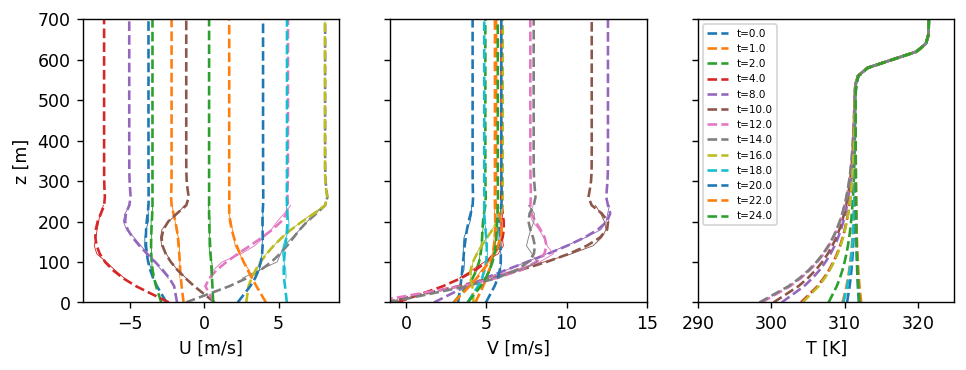

In [9]:
# Plot the original data
iplot = [0, 6, 12, 24, 48, 60, 72, 84, 96, 108, 120, 132, 144]

fig, axs = plt.subplots(1,3, figsize=(9,3), dpi=125, sharey=True)
for i in iplot:
    t = ldr_time[i]
    line, = axs[0].plot(all_U[i,1:maxzN], all_heights[1:maxzN], lw=0.5)
    axs[0].plot(all_Ublend[i,:], all_heights0, color=line.get_color(), linestyle='--', label='t=%0.1f'%(t/3600))
    
    axs[1].plot(all_V[i,1:maxzN], all_heights[1:maxzN], lw=0.5,  color=line.get_color(), label='t=%0.1f'%(t/3600))
    axs[1].plot(all_Vblend[i,:], all_heights0, color=line.get_color(), linestyle='--')
    
    axs[2].plot(all_Tblend[i,:], all_heights0, color=line.get_color(), linestyle='--', label='t=%0.1f'%(t/3600))
    #axs[2].plot(MET_Temp[i,:], MET_heights, color=line.get_color(), linestyle=None, marker='.', lw=0.5)
    
axs[1].set_xlim([-1, 15])
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 700])
axs[2].set_xlim([290, 325])
axs[2].legend(prop={'size':6})


axs[0].set_xlabel('U [m/s]')
axs[1].set_xlabel('V [m/s]')
axs[2].set_xlabel('T [K]')

In [10]:
# Set the temperature flux
fluxdat = []
for i, t in enumerate(ldr_time):
    tflux = PchipInterpolator(b_tflux[:,0], b_tflux[:,1],extrapolate=True)(t)
    fluxdat.append(tflux)
    
fluxdat= 0*np.array(fluxdat)

(-10.0, 2.0)

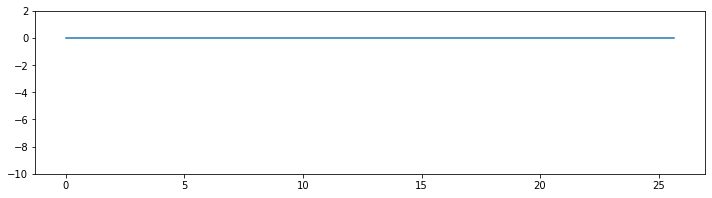

In [11]:
plt.figure(figsize=(12,3))
plt.plot(ldr_time/3600, fluxdat)
plt.ylim([-10,2])

## Save the data

### Conditions
https://www.wunderground.com/history/daily/us/ok/enid/KOKC/date/2023-8-24 

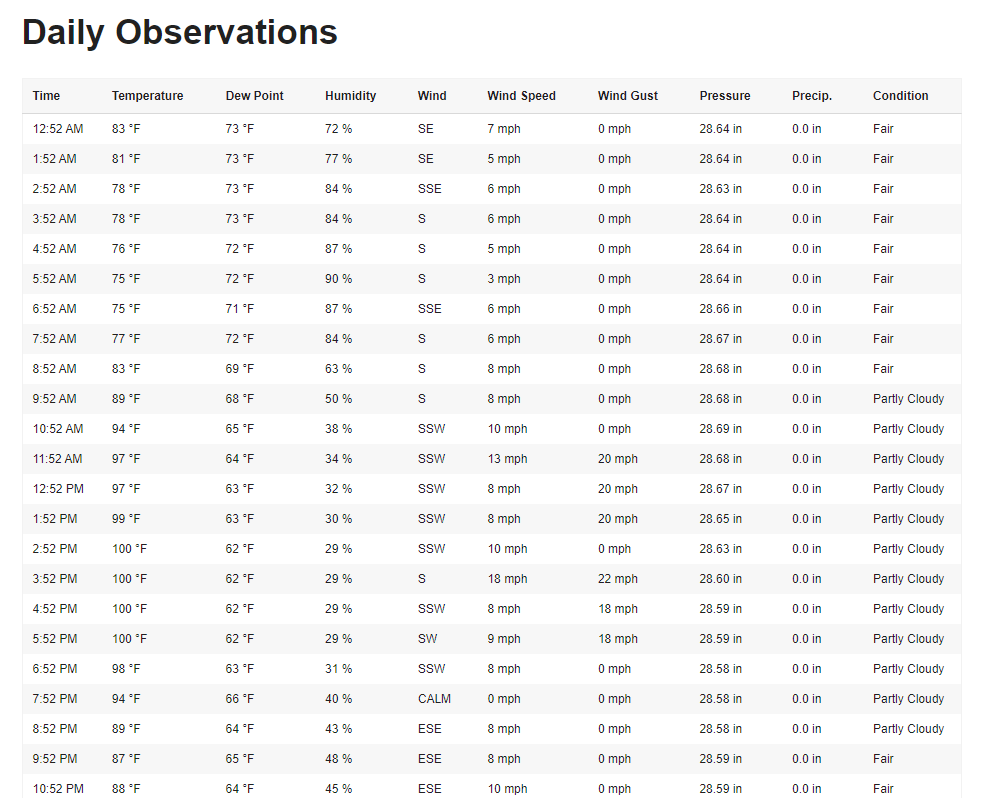

Pressure: 28.64 in Hg = 96986.171 Pa

Temperature: 302 K

Humidity: 87%

Air density: 1.103707 kg/m^3

In [12]:
suffix      = '15'
rundir      = 'MMC_BM1_'+suffix
ICfilename  = 'init.nc'
MMCfilename = 'MMC.nc'
amrfilename = 'abl_HPP_MMC.inp'
rho         = 1.103707

# Go to the run directory
if not os.path.exists(rundir):
    os.makedirs(rundir)

In [13]:
# Save the data to text files
np.savetxt(rundir+'/MMC_Ublend%s.dat'%suffix, all_Ublend)
np.savetxt(rundir+'/MMC_Vblend%s.dat'%suffix, all_Vblend)
np.savetxt(rundir+'/MMC_Tblend%s.dat'%suffix, all_Tblend)
np.savetxt(rundir+'/MMC_all_heights.dat',     all_heights0)
np.savetxt(rundir+'/MMC_time_sec.dat',        ldr_time)

## Set up AMR-Wind case

In [14]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [15]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 36000.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.fixed_dt',  0.50)
case.setAMRWindInput('time.checkpoint_interval',  10000)

In [16]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      rho)                 # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 
                                                                 #   and 284.47 is median air temperature from 2 m above E06, units kg/
case.setAMRWindInput('incflo.velocity',      [0, 0, 0])

In [17]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        -1) 

In [18]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

case.setAMRWindInput('incflo.do_initial_proj', 0)
case.setAMRWindInput('incflo.initial_iterations', 0)

In [19]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [-1920.0,-1920.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [1920.0,  1920.0, 960.0])   # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [384,     384,     96])

In [20]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

In [21]:
# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')    

In [22]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',            ['BoussinesqBuoyancy','ABLMesoForcingMom',])
case.setAMRWindInput('Temperature.source_terms',     ['ABLMesoForcingTemp',])

case.setAMRWindInput('ABL.stats_output_frequency',   1, forcechange=True)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf', forcechange=True)       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 300.0)        # Correspond to what was measured at ARM

case.setAMRWindInput('ABL.perturb_temperature',    True, forcechange=True)
case.setAMRWindInput('ABL.perturb_velocity',       True, forcechange=True)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 300.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


### Set up sampling planes

In [23]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [24]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
sw1, streamwise,  2,  1, 1, 0.5,  0.5,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:0 centery:0 centerz:90 orientation:y outputvars:velocity;tke;temperature outputfreq:10 outputto:sw_
hh,  hubheight,   0,  0,1000, 0,  none,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:0 centery:0 centerz:90 outputvars:velocity;tke;temperature outputfreq:10 outputto:hubheight_
"""

In [25]:
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_sw1', 'Farm_hh']


## MMC parameters

In [26]:
tstart      = 0.0

In [27]:
# Set the MMC inputs
zstr, Tstr = writeMMC.makeIC_fromMMC(case.getAMRWindInput('geometry.prob_lo'), 
                                     case.getAMRWindInput('geometry.prob_hi'), 
                                     case.getAMRWindInput('amr.n_cell'), 
                                     all_Ublend, all_Vblend, all_Tblend,
                                     ldr_time, all_heights0, rundir+'/'+ICfilename, tstart, verbose=True)
writeMMC.makeMMCforcing(case.getAMRWindInput('geometry.prob_lo'), 
                        case.getAMRWindInput('geometry.prob_hi'), 
                        case.getAMRWindInput('amr.n_cell'), 
                        all_Ublend, all_Vblend, all_Tblend, fluxdat,
                        ldr_time, all_heights0, rundir+'/'+MMCfilename)

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', zstr)
case.setAMRWindInput('ABL.temperature_values',  Tstr)

# MMC files
case.setAMRWindInput('ABL.initial_condition_input_file', ICfilename) # this is only for u,v
case.setAMRWindInput('ABL.mesoscale_forcing', MMCfilename)

case.setAMRWindInput('ABLMesoForcingMom.forcing_scheme', "direct")
case.setAMRWindInput('ABLMesoForcingTemp.forcing_scheme', "direct")

#case.setAMRWindInput('ABLMesoForcingMom.forcing_transition',  "directToConstant")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_transition', "directToConstant")
#case.setAMRWindInput('ABLMesoForcingMom.constant_transition_height',  450.0)
#case.setAMRWindInput('ABLMesoForcingTemp.constant_transition_height', 450.0)
#case.setAMRWindInput('ABLMesoForcingMom.transition_thickness',  100.0)
#case.setAMRWindInput('ABLMesoForcingTemp.transition_thickness', 100.0)

[============================================================] 100.0% 
[============================================================] 100.0% 
[============================================================] 100.0% 
NETCDF4
Wrote heights and times
Wrote momentum profiles
Wrote temperature profiles
Wrote tflux profiles
Done


In [28]:
# UNCOMMENT THIS LATER
## Add boundary plane inputs
#case.setAMRWindInput('ABL_useboundaryplane',        True)
#case.setAMRWindInput('ABL.bndry_file',              'bndry_file')
#case.setAMRWindInput('ABL.bndry_io_mode',           '0')
#case.setAMRWindInput('ABL.bndry_planes',            ['xlo','ylo'])
#case.setAMRWindInput('ABL.bndry_output_start_time', 0.0)
#case.setAMRWindInput('ABL.bndry_var_names',         'velocity temperature tke')

In [29]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     14155776             10.0 x 10.0 x 10.0
  TOTAL:     14155776


In [30]:
# Write the input file
print(case.writeAMRWindInput(rundir+'/'+amrfilename))

# --- Simulation time control parameters ---
time.stop_time                           = 36000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             